In [1]:
# create a line plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
series = pd.read_csv('covid.csv', sep=';')
print(series.head())

  dep  sexe        jour  hosp  rea  rad  dc
0  01     0  2020-03-18     2    0    1   0
1  01     1  2020-03-18     1    0    1   0
2  01     2  2020-03-18     1    0    0   0
3  02     0  2020-03-18    41   10   18  11
4  02     1  2020-03-18    19    4   11   6


We sum 'dep' and 'sexe'

In [2]:
tmp=np.zeros(4)
tmpT=np.zeros(4)
dfs = pd.DataFrame(columns = ['date', 'dep','hosp','rea','rad','dc'])
dfsd = pd.DataFrame(columns = ['date','hosp','rea','rad','dc'])
i=0
j=0
for _,content in series.iterrows():
    tmp=tmp+np.array(content[3:])
    if content[1] == 2:
        dfs.loc[i]=[content[2],content[0]]+list(tmp)
        i+=1
        tmpT=tmpT+tmp
        tmp=np.zeros(4)
        i+=1
        if content[0]=='976':
            dfsd.loc[j]=[content[2]]+list(tmpT)
            j+=1
            tmpT=np.zeros(4)
print(dfs.head())
print(dfsd.head())

         date dep  hosp   rea   rad    dc
0  2020-03-18  01   4.0   0.0   2.0   0.0
2  2020-03-18  02  82.0  20.0  36.0  22.0
4  2020-03-18  03   8.0   0.0   2.0   0.0
6  2020-03-18  04   6.0   2.0   4.0   0.0
8  2020-03-18  05  16.0   2.0  18.0   0.0
         date     hosp     rea     rad      dc
0  2020-03-18   5905.0  1535.0  1627.0   435.0
1  2020-03-19   7961.0  1975.0  2322.0   642.0
2  2020-03-20  10272.0  2564.0  3128.0   890.0
3  2020-03-21  11599.0  2872.0  3580.0  1041.0
4  2020-03-22  13675.0  3311.0  4188.0  1251.0


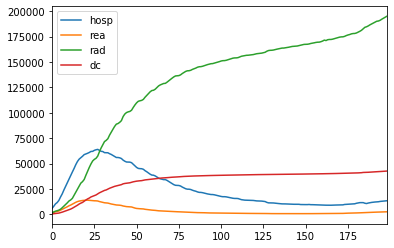

In [4]:
dfsd.plot()
plt.show()

We extract 'rea'

In [6]:
dfsdr=dfsd[['date','rea']]
print(dfsdr.head())

         date     rea
0  2020-03-18  1535.0
1  2020-03-19  1975.0
2  2020-03-20  2564.0
3  2020-03-21  2872.0
4  2020-03-22  3311.0


We make it a list

In [8]:
data=list()
for _,content in dfsdr.iterrows():
    data.append(content[['rea']])
data=np.asarray(data).astype(np.float32)
print(data.shape)
print(data[:5])

(199, 1)
[[1535.]
 [1975.]
 [2564.]
 [2872.]
 [3311.]]


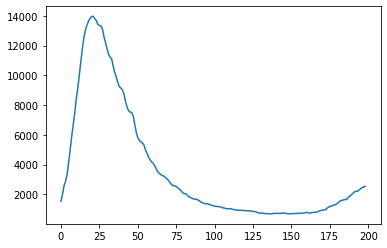

In [9]:
plt.plot(data)
plt.show()

In [13]:
from pandas import concat
from pandas import DataFrame
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

## Dense J+1

Epoch 01432: early stopping


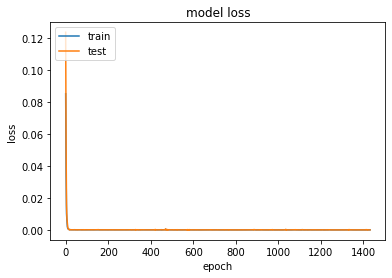

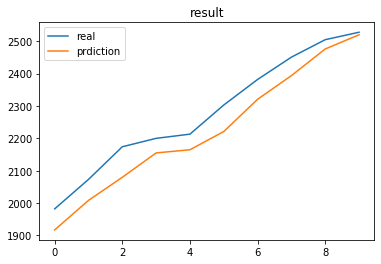

Epoch 00201: early stopping


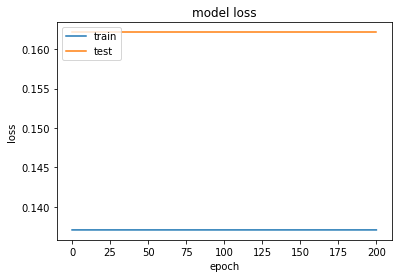

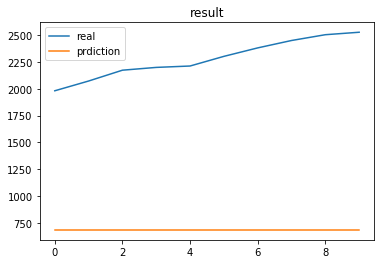

Epoch 00268: early stopping


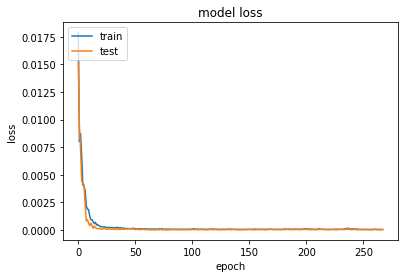

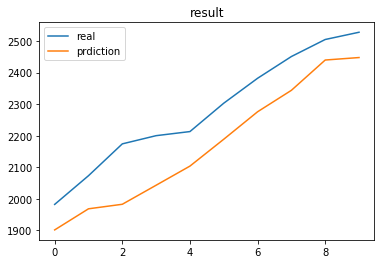

Epoch 00874: early stopping


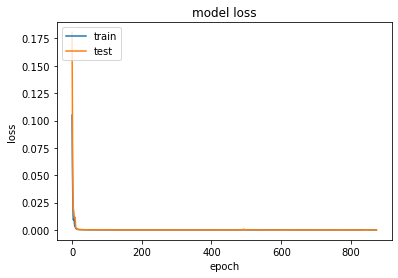

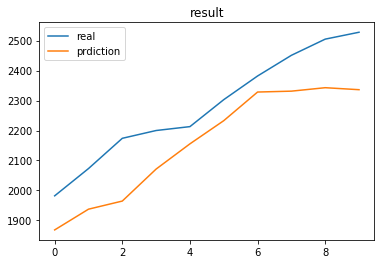

Epoch 01430: early stopping


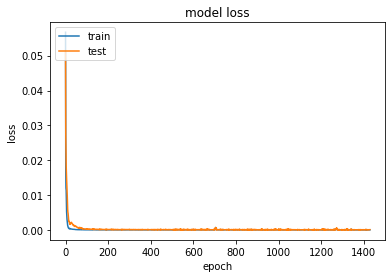

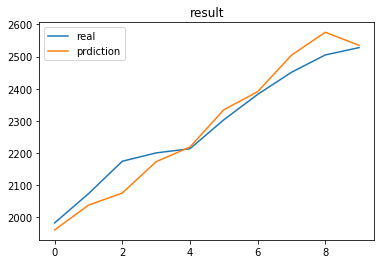

[3.910315717803314e-05, 0.16214145720005035, 1.2850283383158967e-05, 2.1765059500467032e-05, 7.73363935877569e-05]
mlp : 0.032 RMSE (+/- 0.065)


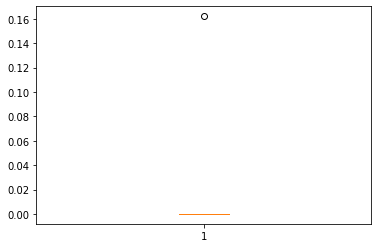

In [16]:
import os
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# fit a model
def model_fit(data, config):
# unpack config
    n_in,n_out, n_nodes, n_epochs, n_batch,p,pl = config
# prepare data
    DATA = series_to_supervised(data, n_in, n_out)
    X, Y = DATA[:, :-n_out], DATA[:, n_in:]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
# define model
    model = Sequential()
    model.add(Dense(4*n_nodes, activation= 'relu', input_dim=n_in))
    model.add(Dense(2*n_nodes, activation= 'relu'))
    model.add(Dense(n_nodes, activation= 'relu'))
    model.add(Dense(n_out, activation= 'relu'))
    model.compile(loss='mse' , optimizer='adam',metrics=['mse'])
# fit
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=p)
    file='best_modelDense.hdf5'
    mc = ModelCheckpoint(filepath=file, monitor='loss', mode='min', verbose=0, save_best_only=True)
    history=model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=n_epochs, verbose=0,batch_size=n_batch, callbacks=[es,mc])
    if pl:
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    saved_model=load_model(file)
    os.remove(file)
    return history.history['val_loss'][-p], saved_model

# repeat evaluation of a config
def repeat_evaluate(data,n_test, config, n_repeat,plot):
    # rescale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    scaled_data=scaler.transform(data)
    scores=[]
    for _ in range(n_repeat):
        score, model= model_fit(scaled_data[:-n_test], config)
        scores.append(score)
    # plot the prediction id asked
        if plot:
            y=[]
            x=[]
            for i in range(n_test,0,-1):
                y.append(float(model.predict(scaled_data[-14-i:-i].reshape(1,14))))
                x.append(scaled_data[-i])
            X=scaler.inverse_transform(x)
            plt.plot(X)
            Y=scaler.inverse_transform(np.array([y]))
            plt.plot(Y.reshape(10,1))
            plt.title('result')
            plt.legend(['real', 'prdiction'], loc='upper left')
        
            plt.show()
    return scores

# summarize model performance
def summarize_scores(name, scores):
# print a summary
    scores_m, score_std = mean(scores), std(scores)
    print( '%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    plt.boxplot(scores)
    plt.show()
    
#setting variable
n_in=14
n_out=1
n_repeat=5
n_test=10
# define config n_in, n_out, n_nodes, n_epochs, n_batch, pateince, draw loss
config = [n_in, n_out, 10, 2000, 50, 200,True]
# compute scores
scores = repeat_evaluate(data,n_test, config, n_repeat, True)
print(scores)
# summarize scores
summarize_scores('mlp ', scores)